In [ ]:
%%capture --no-stderr
# % pip install -U langgraph langchain langchain_community, langchain_anthropic

In [ ]:
%env LANGCHAIN_TRACING_V2=true

## Prerequisites

We'll fetch our flight DB from storage to use locally.

In [1]:
import os
import requests
import sqlite3
import io
import pandas as pd
from datetime import datetime, timedelta


db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"

if not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)

# Convert the flights to present time for our tutorial
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn).name.tolist()
tdf = {}
for t in tables:
    tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

example_time = pd.to_datetime(tdf['flights']['actual_departure'].replace('\\N', pd.NaT)).max()
current_time = pd.to_datetime('now').tz_localize(example_time.tz)
time_diff = current_time - example_time

tdf['bookings']['book_date'] = pd.to_datetime(thdf['bookings']['book_date'].replace('\\N', pd.NaT)) + time_diff

datetime_columns = ['scheduled_departure', 'scheduled_arrival', 'actual_departure', 'actual_arrival']
for column in datetime_columns:
    tdf['flights'][column] = pd.to_datetime(tdf['flights'][column].replace('\\N', pd.NaT)) + time_diff

for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists='replace', index=False)
# del df
# del tdf
conn.commit()
conn.close()

## State

In [2]:
from langgraph.graph.message import add_messages, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str

## Tools

#### Search Flights

Search the current flights in the DB.

In [42]:
from langchain_core.tools import tool
from langchain_core.runnables import ensure_config
from typing import Optional
import sqlite3
from datetime import datetime, timedelta


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[datetime] = None,
    end_time: Optional[datetime] = None,
    limit: int = 100,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    db = configuration["db"]
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

#### Fetch the user's flight information

This tool lets the agent look up all flight information associated with the configured user.

In [43]:
@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    db = configuration["db"]
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results

#### Update ticket

This tool lets the assistant reschedule the user's flights, if a new flight is available.

TODO: Add constraints that follow company policy (cannot rebook if the flight is only 3 hours from  now, etc.

In [44]:
@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    db = configuration["db"]

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    cursor.execute(
        "SELECT departure_airport, arrival_airport FROM flights WHERE flight_id = ?",
        (current_flight[0],),
    )
    current_airports = cursor.fetchone()
    if new_flight != current_airports:
        cursor.close()
        conn.close()
        return "New flight does not match the original departure and arrival airports."

    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."

## Lookup Company Policies

The assistant can look up information about company polices using a retriever.

In [45]:
import re
import numpy as np
import openai

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc['page_content'] for doc in docs])

#### User info node

In [46]:
def user_info(state: State):
    return {"user_info":  fetch_user_flight_information.invoke({})}

In [47]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
tools = [TavilySearchResults(max_results=1), search_flights, lookup_policy]
sensitive_tools = [update_ticket_to_new_flight]
sensitive_tool_names = {t.name for t in sensitive_tools}

llm = ChatAnthropic(model="claude-3-haiku-20240307")

prompt = ChatPromptTemplate.from_messages([
    ("system", 
     "You are a helpful customer support assistant for Swiss Airlines. "
    "Where appropriate, use the provided tools to assist the user in managing their flights."
    "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"),
    ("placeholder", "{messages}")
])

assistant_runnable = prompt | llm.bind_tools(tools + sensitive_tools)
def assistant(state: State):
    return {"messages": assistant_runnable.invoke(state)}

In [48]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph, END

builder = StateGraph(State)
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", assistant)
builder.add_node("safe_tools", ToolNode(tools))
builder.add_node("sensitive_tools", ToolNode(tools + sensitive_tools))
builder.add_edge("sensitive_tools", "fetch_user_info")
builder.add_edge("fetch_user_info", "assistant")
# Fetch the user info again in case it was updated
builder.add_edge("safe_tools", "fetch_user_info")

def route_tools(state: State):
    selected = tools_condition(state)
    if selected == "action":
        # Check if we need to get user confirmation
        ai_message = state['messages'][-1]
        tools_called = [t['name'] for t in ai_message.tool_calls]
        if any(name in sensitive_tool_names for name in tools_called):
            return "sensitive_tools"
    return selected
builder.add_conditional_edges(
    "assistant", route_tools, {"action": "safe_tools", END: END, "sensitive_tools": "sensitive_tools"}
)
checkpointer = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(interrupt_before=["sensitive_tools"], checkpointer=checkpointer)

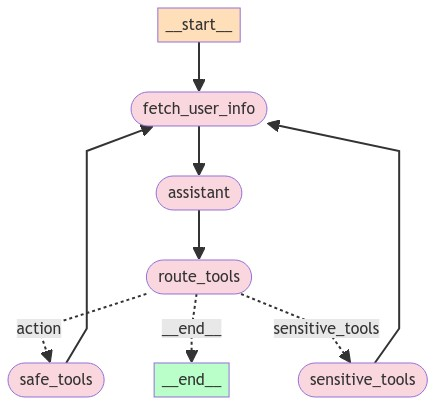

In [49]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [50]:
config = {
    "configurable": {
        "passenger_id": "3442 587242",
        "db": local_file,
        "thread_id": "thread-1",
    }
}
events = graph.stream(
    {"messages": [("user", "Hi there, what time is my flight?")]},
    config,
    stream_mode="values",
)
for event in events:
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        print(
            message.type,
            str(message.content).replace("\n", "\\n")[:200],
        )

human Hi there, what time is my flight?
human Hi there, what time is my flight?
ai I'm sorry, but I don't have any information about your flight times or itinerary. Could you please provide me with more details about your booking, such as your ticket number or confirmation code? Tha


In [53]:
events = graph.stream(
    {"messages": [("user", "Am i allowed to update my flight to something sooner? I want to leave later today.")]}, config, stream_mode="values"
)
for event in events:
    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            messages = messages[-1]
        print(
            message.type,
            str(messages.content).replace("\n", "\\n")[:200],
        )

In [ ]:
events = graph.stream(
    {"messages": [("user", "Update my flight to something later actually.")]}, config, stream_mode="values"
)
for event in events:
    messages = event.get("messages")
    if messages:
        if isinstance(messages, list):
            messages = messages[-1]
        print(
            "Assistant:",
            str(messages.content).replace("\n", "\\n")[:200],
        )